# Example-2 of MaxFuse usage between RNA and Protein modality.

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

import seaborn as sns
import os

import warnings
warnings.filterwarnings('error', category=DeprecationWarning)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing

In [2]:
# read in protein data
data_dir = './../../../neighborhood/CRC_related/'
protein = pd.read_csv(os.path.join(data_dir, 'crc_codex/CRC_clusters_neighborhoods_markersV2.csv')) # ~258,000 codex cells

# Remove tumor cells in CODEX and some other cells

In [3]:
np.unique(protein['ClusterName'])

array(['B cells', 'CD11b+ monocytes', 'CD11b+CD68+ macrophages',
       'CD11c+ DCs', 'CD163+ macrophages', 'CD3+ T cells', 'CD4+ T cells',
       'CD4+ T cells CD45RO+', 'CD4+ T cells GATA3+', 'CD68+ macrophages',
       'CD68+ macrophages GzmB+', 'CD68+CD163+ macrophages',
       'CD8+ T cells', 'NK cells', 'Tregs', 'adipocytes', 'dirt',
       'granulocytes', 'immune cells', 'immune cells / vasculature',
       'lymphatics', 'nerves', 'plasma cells', 'smooth muscle', 'stroma',
       'tumor cells', 'tumor cells / immune cells', 'undefined',
       'vasculature'], dtype=object)

In [4]:
macro_list = ['CD68+CD163+ macrophages']

In [5]:
protein_macro = protein[protein['ClusterName'].isin(macro_list)]

In [6]:
protein_macro.shape

(39596, 101)

# Rename protein

In [7]:
protein_features = list(protein.columns[13:62]) + list(protein.columns[70:79])
protein_new_exp = protein_macro[protein_features]

In [8]:
protein_new_exp.shape

(39596, 58)

In [9]:
import re
protein_new_exp = protein_new_exp.rename(columns=lambda x: re.sub(' -.*','',x))

In [10]:
# convert to AnnData
protein_adata = ad.AnnData(
    protein_new_exp.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein_new_exp.columns

In [11]:
protein_adata.X.shape

(39596, 58)

# Remove tumor cells in RNA

In [12]:
data_dir = './../../../neighborhood/CRC_related/'
counts = sc.read_10x_h5(os.path.join(data_dir, 'hacohen_scrna/data/GSE178341_crc10x_full_c295v4_submit.h5'))

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/scanpy/readwrite.py:281: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
cluster = pd.read_csv(os.path.join(data_dir, 'hacohen_scrna/data/GSE178341_crc10x_full_c295v4_submit_cluster.csv'))
#cluster.head()

In [14]:
np.unique(cluster.clMidwayPr)

array(['B', 'DC', 'Endo', 'Epi', 'Fibro', 'Granulo', 'ILC', 'Macro',
       'Mast', 'Mono', 'NK', 'Peri', 'Plasma', 'Schwann', 'SmoothMuscle',
       'TCD4', 'TCD8', 'TZBTB16', 'Tgd'], dtype=object)

In [15]:
cancer_cell_index = cluster[cluster.clMidwayPr == 'Epi'].index

In [16]:
macro_index = cluster[cluster.clMidwayPr == 'Macro'].index

In [17]:
len(macro_index)

20280

# Remove normal tissues in RNA

In [18]:
metapat = pd.read_csv(os.path.join(data_dir,'hacohen_scrna/data/GSE178341_crc10x_full_c295v4_submit_metatables.csv'))

In [19]:
normal_tissue_index = metapat[metapat.HistologicTypeSimple == 'Normal colon'].index

In [20]:
normal_tissue_index

Int64Index([ 12263,  12264,  12265,  12266,  12267,  12268,  12269,  12270,
             12271,  12272,
            ...
            339661, 339662, 339663, 339664, 339665, 339666, 339667, 339668,
            339669, 339670],
           dtype='int64', length=112864)

In [21]:
#rows_to_remove = list(cancer_cell_index) + list(normal_tissue_index)

In [22]:
from tqdm import tqdm
filtered_rows = []
for i in tqdm(range(counts.n_obs), desc="Filtering rows"):
    #if i not in rows_to_remove:
    if (i in list(macro_index)) and (i not in list(normal_tissue_index)):
        filtered_rows.append(i)

Filtering rows:  36%|██████▍           | 133580/370115 [03:47<05:22, 734.48it/s]

In [23]:
macro_adata = counts[filtered_rows, :]

In [24]:
macro_adata

In [25]:
filtered_adata = counts[filtered_rows, :]

In [26]:
filtered_adata #144035 x 43113

In [27]:
rna_adata = macro_adata

In [28]:
rna_adata.var_names_make_unique()

In [29]:
rna_adata.write(os.path.join(data_dir, "hacohen_scrna/data/rna_processed_macro_163.h5"))

In [14]:
rna_adata = sc.read_h5ad(os.path.join(data_dir, "hacohen_scrna/data/rna_processed_macro_163.h5"))
rna_adata

AnnData object with n_obs × n_vars = 18976 × 43113
    var: 'gene_ids', 'feature_types', 'genome'

# Name conversion between protein and RNA

In [16]:
correspondence = pd.read_csv(os.path.join(data_dir, 'pro_rna_conv_0615_23.csv'))
#correspondence = pd.read_csv('./../CRC_related/protein_rna_name_conversionV8.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [17]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [18]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()
print([rna_shared.shape,protein_shared.shape])

[(18976, 60), (39596, 60)]


/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [19]:
# Make sure no column is static
mask = (
    (rna_shared.X.toarray().std(axis=0) > 0.01) 
    & (protein_shared.X.std(axis=0) > 0.01)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(18976, 60), (39596, 60)]


In [20]:
# process rna_shared
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)
rna_shared = rna_shared.X.copy()

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [21]:
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)
protein_shared = protein_shared.X.copy()

In [22]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [23]:
# process all protein features
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)

In [24]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

## Get subset numbers for better speed

In [25]:
#indx1 = np.random.choice(rna_active.shape[0], 18000)
#indx2 = np.random.choice(protein_active.shape[0], 35000)

## Fitting MaxFuse

### Step I: preparations

In [26]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [27]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
#fusor = mf.model.Fusor(
#    shared_arr1=rna_shared[indx1,:],
#    shared_arr2=protein_shared[indx2,:],
#    active_arr1=rna_active[indx1,:],
#    active_arr2=protein_active[indx2,:],
#    labels1=None,
#    labels2=None
#)

In [28]:
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 18976, and max batch size is 18976.
The second data is split into 1 batches, average batch size is 39596, and max batch size is 39596.
Batch to batch correspondence is:
  ['0<->0'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

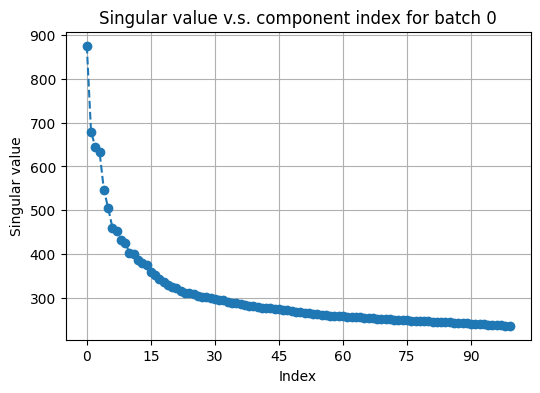

In [29]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

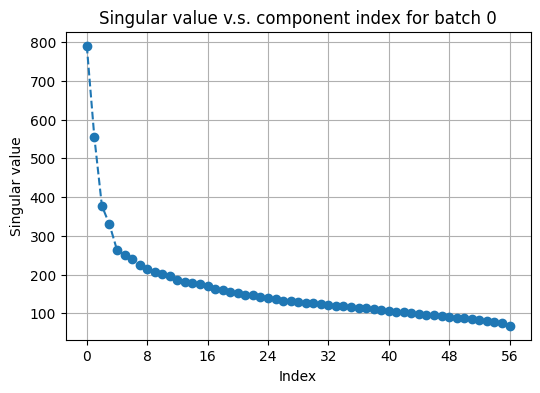

In [30]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [31]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=45,
    svd_components2=40,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


### Step II: finding initial pivots

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

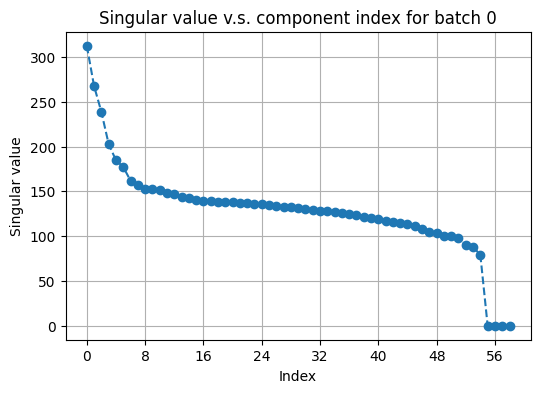

In [32]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

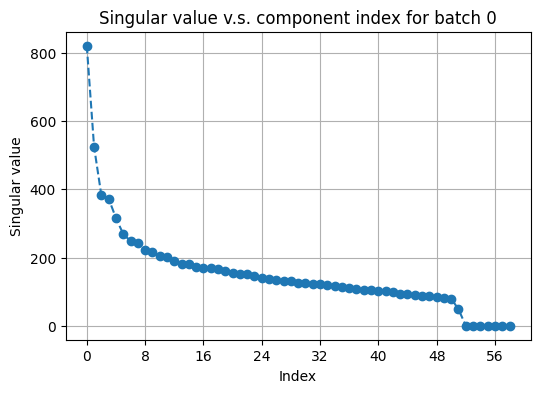

In [33]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [34]:
fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=56, svd_components2=56
)

Now at batch 0<->0...
Done!


### Step III: finding refined pivots

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

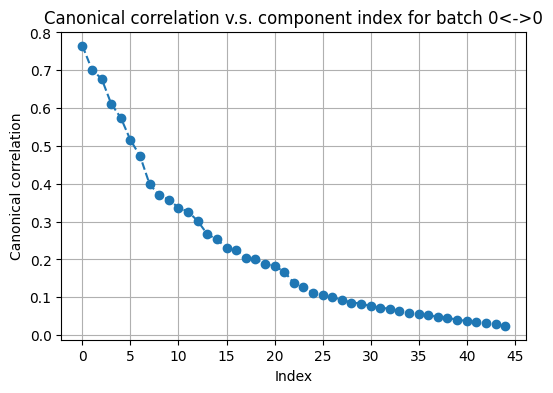

In [35]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)

In [36]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=50, svd_components2=None,
    cca_components=30,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [37]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
6639/9485 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
13221/18976 cells in arr1 are selected as pivots.
6639/39596 cells in arr2 are selected as pivots.
Done!


**Note:** Since we have the `refine_pivots` now, we can theoratically co-embedding the *full* dataset into CCA space (as described in `tutorial-1`). **However**, in the case that invovles *low-snr* datasets (eg. spatial-omics), we do not suggest projecting all the cells into a common space without any filtering steps. We will describe this process after the `propogation` step.

### Step IV: propagation

Refined pivots can only give us a pivot matching that captures a subset of cells. In order to get a *full* matching that involves all cells during input, we need to call `propagate`.


In [38]:
fusor.propagate(
    svd_components1=50, 
    svd_components2=None, 
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Done!


We call `filter_bad_matches` with `target=propagated` to optionally filter away a few matched pairs from propagation. 

**Note:** In the best scenario, we would prefer all cells in the *full* dataset can be matched accross modality. However, in the case that invovles *low-snr* datasets (eg. spatial-omics), many cells are noisy (or lack of information) and should not be included in downstream cross-modality analysis. We suggest in such scenarios, `filter_prop` should be set around *0.1-0.4*.

In [39]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3
)

Begin filtering...
Now at batch 0<->0...
25062/35803 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


We use `get_matching` with `target='full_data'` to extract the full matching.

Because of the batching operation, the resulting matching may contain duplicates. The `order` argument determines how those duplicates are dealt with. 
`order=None` means doing nothing and returning the matching with potential duplicates;
`order=(1, 2)` means returning a matching where each cell in the first modality contains *at least one match* in the second modality;
`order=(2, 1)` means returning a matching where each cell in the second modality contains *at least one match* in the first modality.

**Note:** Since we filtered out some cell pairs here, not all cells in the full dataset has matches.

In [40]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [41]:
len(full_matching[0])

31587

Since we are doing `order=(2, 1)` here, the matching info is all the cells (10k) in mod 2 (protein) has at least one match cell in the RNA modality. Note that the matched cell in RNA could be duplicated, as protein cells could be matched to the same RNA cell. For a quick check on matching format:

In [42]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,14980,0,0.611908
1,570,2,0.626506
2,6982,4,0.712110
3,9840,9,0.463825
4,18541,12,0.554991
...,...,...,...
31582,9056,39590,0.220474
31583,8227,39591,0.276874
31584,9527,39592,0.452808
31585,17162,39594,0.507636


(array([  15.,   80.,  500., 1955., 5007., 7866., 8456., 5729., 1818.,
         161.]),
 array([-0.33024178, -0.20159822, -0.07295466,  0.0556889 ,  0.18433245,
         0.31297601,  0.44161957,  0.57026313,  0.69890668,  0.82755024,
         0.9561938 ]),
 <BarContainer object of 10 artists>)

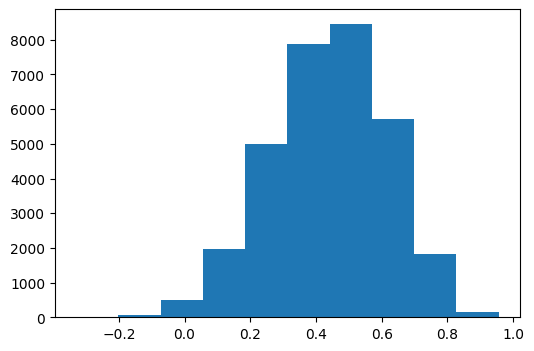

In [43]:
plt.hist(full_matching[2])

(array([  15.,   99.,  449., 1727., 4458., 8123., 9247., 7009., 2652.,
         414.]),
 array([-0.35540966, -0.2273426 , -0.09927554,  0.02879152,  0.15685857,
         0.28492563,  0.41299269,  0.54105975,  0.6691268 ,  0.79719386,
         0.92526092]),
 <BarContainer object of 10 artists>)

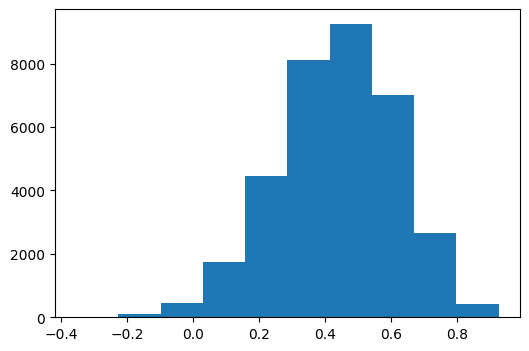

In [58]:
plt.hist(full_matching[2])

In [44]:
df_res = pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
df_res.to_csv('./results/crc_codex_rna_macro_163_0318.csv', index=False)

In [60]:
np.max(df_res['mod2_indx'])

43424